# Working with the MaiCuBeDa database
https://heidata.uni-heidelberg.de/dataset.xhtml?persistentId=doi:10.11588/data/QSNIQ2&version=1.0

- Holds W3C annotations of renderings of 3D models of cuneiform tablets extracted from HeiCuBeDa, including cropped images representing areas per annotation
- The database creators used only those transliterations for sourcing they deemed reliable as and that were present in the renderings, rather than reconstructed from existing context
- The annotation process underwent multiple different consistency tests

## Structure:
Two different source folders, one “Mixed”, the other “MSII” and each source contains subfolders:
- char
- charannotations
- croppoly_char
- croppoly_wedge
- line
- lineannotations
- wedge
- word
- wordannotations

| ID | Filename | CDLI_Number | IRI | HeidIcon | Time_period | Language | side | bbox | column | line | charindex | charname | transliteration |
|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... |

Important here are
| Filename | ... | transliteration |
|-------|-------|-------|
| 1_3(disz)_1_1_1_2_HS_1137_06_back.jpg | ... | 1/3(disz) |

(TRANS/)_TRANSLITERATION_UNKNOWN_COLUMN_LINE_CHARINDEX_TABLETNAME_SURFACE

Problem: some rows in column “transliteration” contained delimiter “;” between transliteration signs —> inconsistent columns when creating dataframe
- had to open CSV file in excel to insert  “transliteration_2” which automatically
	adds “;” at end of normal rows but groups those with false delimiter in new col
- File now parseable
- Added HeidIcon as Column name for proper indexing

The images in folder char are named in this schema:
| TRANSLITERATION_COLUMN_LINE_CHARINDEX_TABLETNAME_SURFACE |
|-------|
|  1_3(disz)_1_1_2_HS_1137_06_back.png |

Note that the transliteration 1/3(disz) is part of the image name but uses the seperator "_" instead of "/"
and that the names 

In [74]:
import os
# describe the structure of project folders:

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
folder_path = os.path.join(parent_dir, "Cuneiform Tests", "MaiCuBeDa", "MaiCuBeDa_Annotations_Mixed","char")

print(folder_path)

/Users/Uni/Documents/Uni/Thesis/Cuneiform Tests/MaiCuBeDa/MaiCuBeDa_Annotations_Mixed/char


#### Dataframe Creation - Markdown
(And removing whitespace from col names)

In [75]:
import numpy as np 
import pandas as pd

metadata_path = os.path.join(parent_dir, "Cuneiform Tests", "MaiCuBeDa", "dataverse_files", "translitmetadata(in).csv")

csv = pd.read_csv(metadata_path, sep=";", encoding="utf-8")
df_metadata = pd.DataFrame(csv)
# from columns, remove whitespaces
df_metadata.columns = df_metadata.columns.str.strip()

df_metadata.head(1)

,ID,Filename,CDLI_Number,IRI,HeidIcon,Time_period,Language,Genre,side,bbox,column,line,charindex,charname,transliteration,transliteration_2
0,HS_1137_06,1_3(disz)_1_1_1_2_HS_1137_06_back.jpg,P134449,http://cdli.ucla.edu/P134449_back_char_1_2,https://heidicon.ub.uni-heidelberg.de/iiif/2/1...,Ur III (ca. 2100-2000 BC),Sumerian,Administrative,back,"[155, 279, 23, 111]",-1,1,2,SZUSZANA_(13) ...,1/3(disz),NaN


#### Fixing Dataframe indexing
after adding column "transliteration_2" for consistent col count, appending its content to "transliteration" and dropping it


In [76]:
# count all entries of "transliteration_2" that are not empty
count = df_metadata["transliteration_2"].count()

# for each row check if column "translatitertion_2" is empty,
# otherwise, append string-content of column to "translatitertion"
test = 0
for index, row in df_metadata.iterrows():
    # remove whitespace at end of transliteration string
    transl = row["transliteration"].strip()
    transl2 = row["transliteration_2"]
    if pd.notnull(transl2):
        # new string is concatenation of transliteration and transliteration_2
        row["transliteration"] = transl + ", " + transl2
        #print(row)
        test += 1
print("Cols with transliteration_2:\t", count, "\n", "Operations performed:\t\t", test, "\n", "Success:\t\t\t", count == test)

if count == test:
    # drop column "transliteration_2"
    df_metadata = df_metadata.drop(columns=["transliteration_2"])

# get the 22077th entry from metadata
df_metadata["transliteration"].loc[22068]


Cols with transliteration_2:	 51 
 Operations performed:		 51 
 Success:			 True


'ARAD2_(ARADKUR), arad2'

#### Dataframe Creation - Images

In [77]:
images = os.listdir(folder_path)
df_images = pd.DataFrame(images, columns=["filename"])

#### Extract corresponding Char literal from image name
Problem: Some numbered cunei chars are given in format numeral_numeral(char) and have to be combined into the fitting description numeral/numeral(char) to match their exact transliteration in metadata.

*e.g. "1/3(asz@c)" in "1_3(asz@c)_1_-1_-1_HS_793_06_back.png"*

In [78]:
# create new column "char" in df_images from filenames
df_images["char"] = df_images["filename"].str.split("_")

size_before = df_images.filename.size

for index, row in df_images.iterrows():
    # if first elem is a number than merge with second elem
    if row["char"][0].isdigit():
        # keep only transliteration (elem 1-2)
        df_images.at[index, "char"] = row["char"][0] + "/" + row["char"][1]
    else:
        df_images.at[index, "char"] = row["char"][0]
    # files not containing a transliteration are not needed:
    if row["char"][0] == "":
        df_images = df_images.drop(index)

size_after = df_images.filename.size
print("No. of removed rows:\t", size_before - size_after)


#df_images.loc[0]
# get the row where filename is "1_3(asz@c)_1_-1_-1_HS_793_06_back.png" --> df_image.loc[5178]

No. of removed rows:	 39


In [79]:
# save dataframe to csv if not yet existing
df_images.to_csv("df_images.csv", sep=";", encoding="utf-8")

# count cols
count = df_images["char"].count()
print("No. of rows with 'char':\t", count)

No. of rows with 'char':	 27729


#### Get number of unique chars to define output classes

In [80]:
# number of unique characters in df_images['char']
unique_chars = df_images["char"].nunique()
print(unique_chars)

918


## Train CNN

In [81]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.models import Sequential

import gc

# run gc.collect() to free up memory
gc.collect()

image_size = 50

# Load the images
images = np.array([img_to_array(load_img(folder_path+"/"+img_path, target_size=(image_size, image_size), color_mode='grayscale')) for img_path in df_images.iloc[:, 0]])

# Reshape the images
images = images.reshape(-1, image_size, image_size, 1)

# Create a Sequential model
model = Sequential()

# Add a Conv2D layer with 32 filters, a 3x3 kernel, and 'relu' activation function
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(image_size, image_size, 1)))

# Add another Conv2D layer with 64 filters and a 3x3 kernel
model.add(Conv2D(64, kernel_size=3, activation='relu'))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a Dense layer with 128 units and 'relu' activation function
model.add(Dense(128, activation='relu'))

# Add an output Dense layer with 918 units (for all unique labels)
# softmax activation function is used for multi-class classification
model.add(Dense(unique_chars, activation='softmax'))

# Compile the model
# sparse_categorical_crossentropy --> classes > 2
# "adam" optimizer --> the best learning rate or 'sgd' (stoch. gradient descent)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Convert char-labels to integers for training
le = LabelEncoder()
labels = le.fit_transform(df_images.iloc[:, 1])

In [ ]:
# Train the model
model.fit(images, labels, validation_split=0.2, epochs=5)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 135424)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    17,334,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 918)            │       118,422 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,471,640 (66.65 MB)

 Trainable params: 17,471,638 (66.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

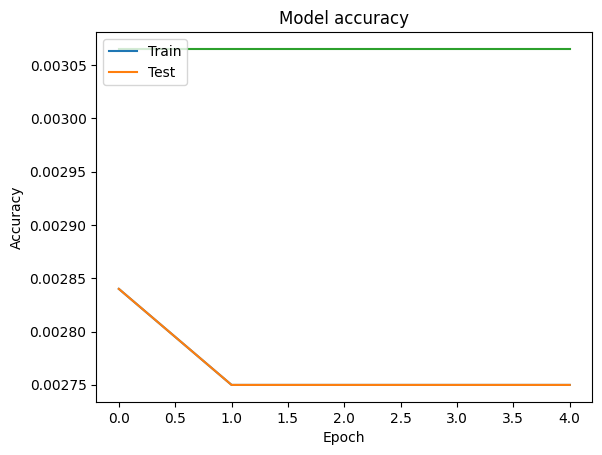

In [ ]:
import os
import matplotlib.pyplot as plt

# plt model acc and loss during training
plt.plot(model.history.history.get('accuracy'))
model.summary()
'''
# save model and created plot with timestamp
timestamp = pd.Timestamp.now().strftime("%d.%m.%Y_%H:%M:%S")
model_name = model.name
plt.savefig(model_name+"_"+"model_acc_"+timestamp+".png")
# save model under name "first_model" in directory model_outputs
model.save('model_outputs/first_'+timestamp+".keras")
'''

# Plot training & validation accuracy values
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# save model and created plot with timestamp
model_name = model.name
timestamp = pd.Timestamp.now().strftime("%d.%m.%Y_%H:%M:%S")
model.save('model_outputs/first_'+timestamp+".keras")
plt.savefig('model_outputs/first_'+timestamp+"_model_acc.png")

# Plot training & validation accuracy values
model_history = pd.DataFrame(model.history.history)
model_history.to_csv('model_outputs/first_'+timestamp+"_history.csv", index=False)

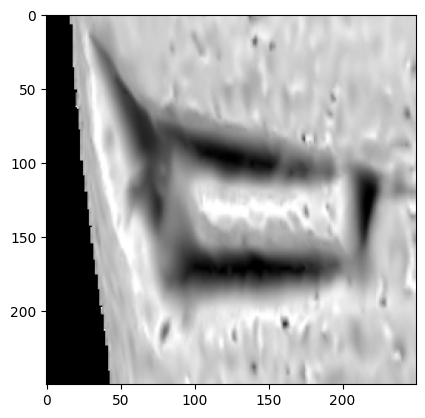

In [ ]:
from matplotlib import pyplot as plt
import cv2

test = df_images["filename"].loc[5]
img = cv2.imread(os.path.join(folder_path, test))
plt.imshow(img)
